In [1]:
import src.models.question1 as q1
import src.models.question2 as q2
import src.models.question3 as q3
import src.models.question4 as q4
import src.models.question5 as q5
import src.models.question6 as q6

%load_ext autoreload
%autoreload 2

# Results

## Analysis

### 1. Ratings Comparison: Oscar Winners vs. Nominees vs. Box-Office Hits

Are Oscar-winning movies generally better received than those that were only nominated?  
And how do they compare to the top performers at the box office?

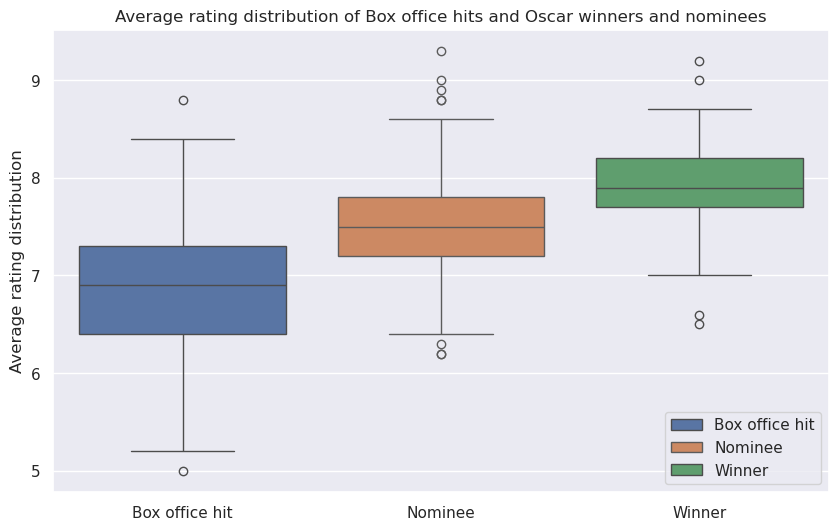

In [2]:
q1.plot_winner_vs_nominees_vs_box_office_hit_ratings()

We observe that, on average, Oscar-winning movies receive higher ratings than those that were simply nominated.  
Additionally, we notice that the distribution for box office hits is much broader, highlighting that a successful movie might not always be well-received by its audience.

In [3]:
# We perform a t-test to determine if the ratings of the winners are significantly different from the ratings of the nominees
q1.print_ttest_winner_vs_nominees_ratings()

T-statistic:  4.292684871161048
P-value:  2.42991213460508e-05


We observe that the p-value is very small ($<1\%$).  
Thus, we can reject the null hypothesis and initially conclude that the distribution of ratings between Oscar winners and nominees is significantly different.

#### Rating gap between the oscar winner and best rated movie

Another question we might consider is whether the Oscar-winning movie is also viewed as the best by audiences (i.e., the highest-rated movie of that year).

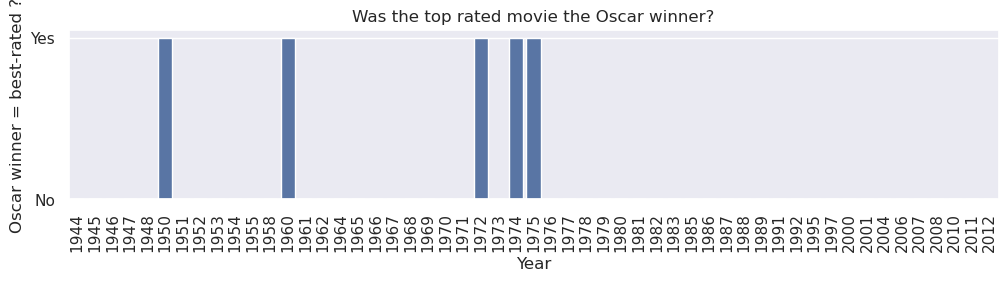

In [4]:
q1.plot_oscar_winners_vs_audience_concordance()

We observe that, most of the time, the Oscar's best movie differs from the audience's choice.  
Now, let’s examine the rating gap between the Oscar winner and the top-rated movie.

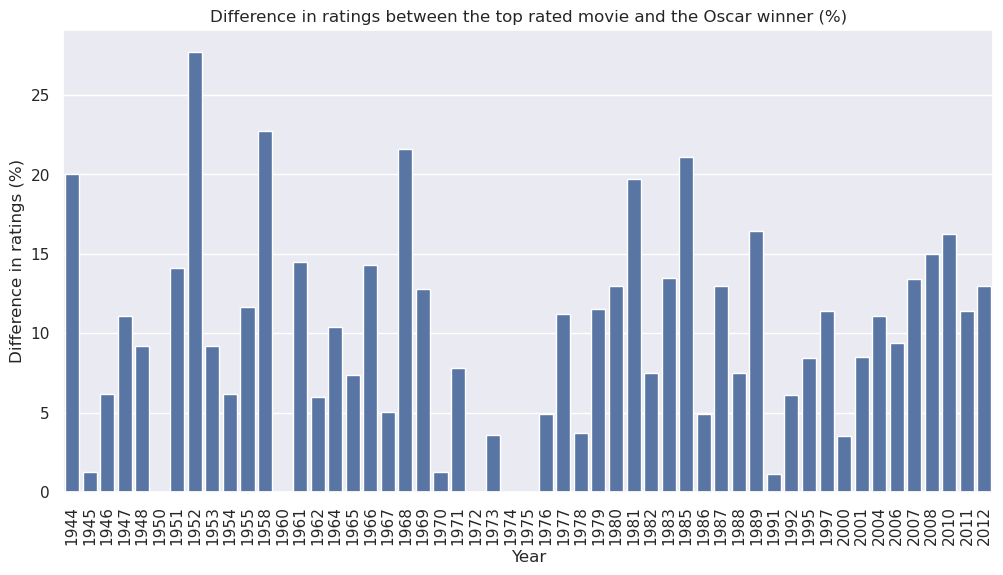

In [5]:
q1.plot_oscar_winners_vs_audience_ratings_gap()

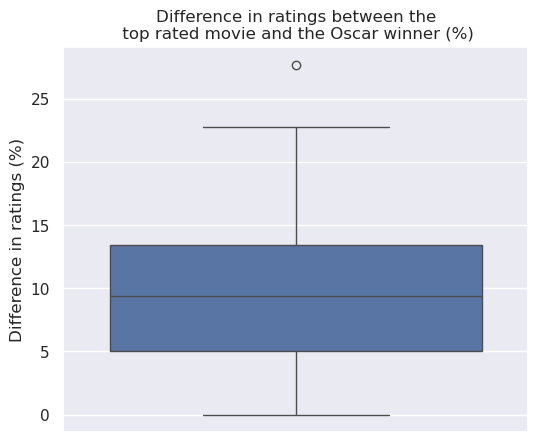

In [6]:
q1.plot_oscar_winners_vs_audience_ratings_gap_box()

On average, we observe a 10% rating difference between the Oscar winner and the year’s top-rated movie.  
This suggests that opinions on the best movie differ substantially between Oscar judges and the audience.

### 2. Ratings Over Time: Do Oscar Winners "Age Well"?

In order to quantify the "sentiment" of the reviews (positive/negative), we use an open source sentiment analysis tool called "vaderSentiment", which computes the "compound score" of each movie review. The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules of the tool, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This useful metric gives a single unidimensional measure of sentiment for a given sentence.

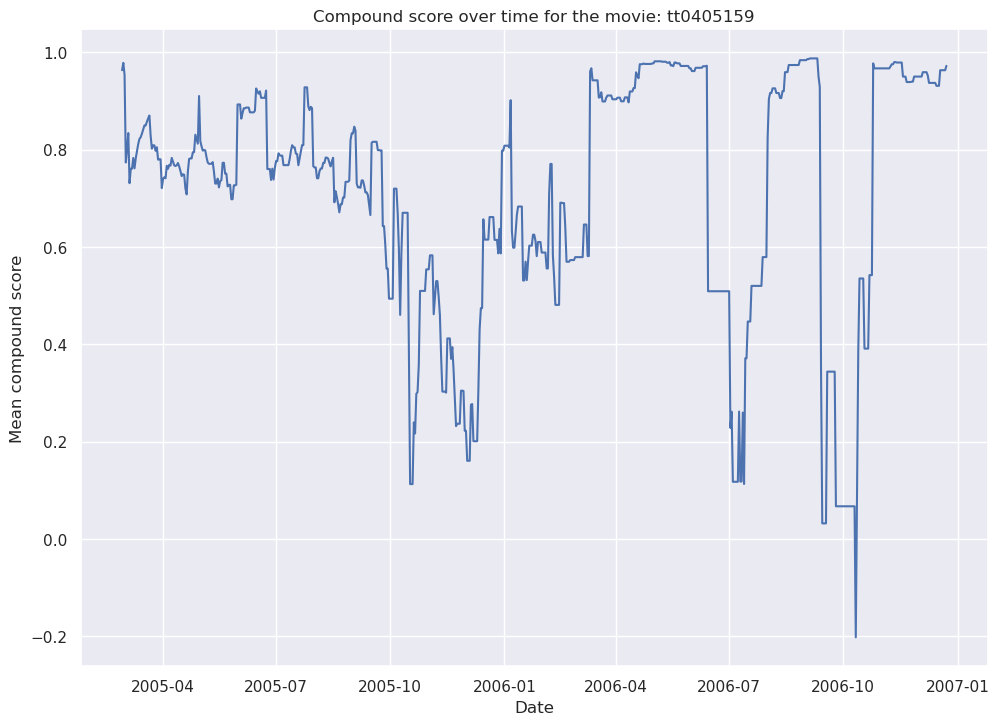

In [7]:
q2.plot_oscar_timeline("compound")

We observe a lot of fluctuations with time. Further analysis with other movies could show us if this is a global trend (here we only plot the case of one award winning movie).

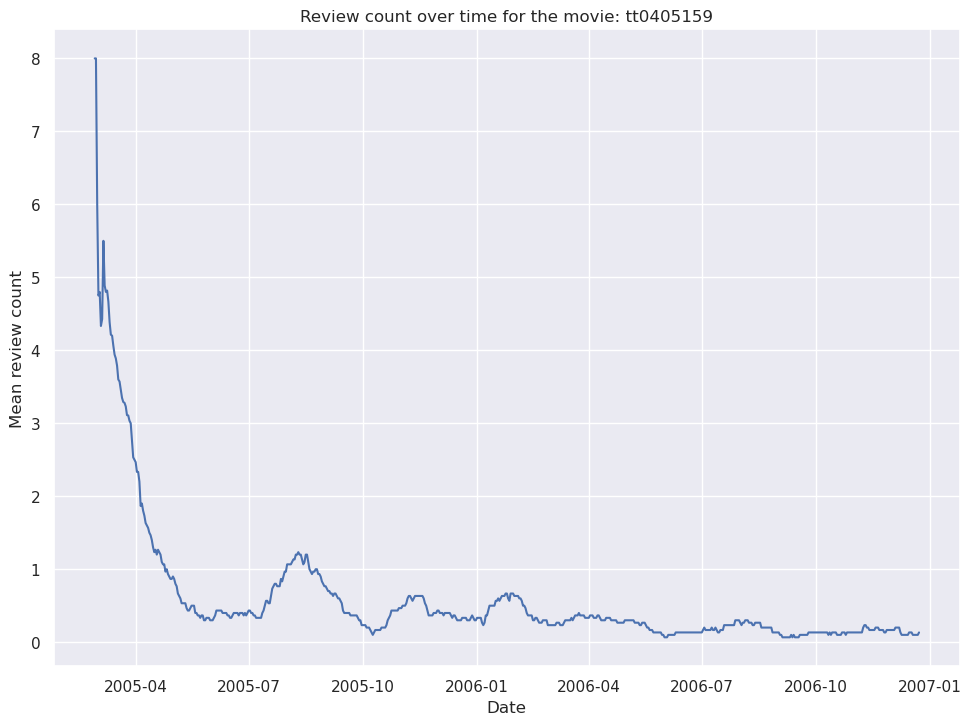

In [8]:
q2.plot_oscar_timeline("count")

The number of reviews decreases with time after the oscar ceremony. This needs to be taken into account when reviewing the compound score timeline (less data with time)

### 3. Impact of High-Profile Actors/Directors on Oscar Wins

Do Oscar judges favor any high profile director? This is the question we will be answering to in this section.

To estimate how popular a director was at the year of the given oscar ceremony, we set a 'high profile score' as the mean of all the box office revenue the director has participated in before the oscar ceremony.

In [9]:
df_Q3 = q3.load_data_Q3()

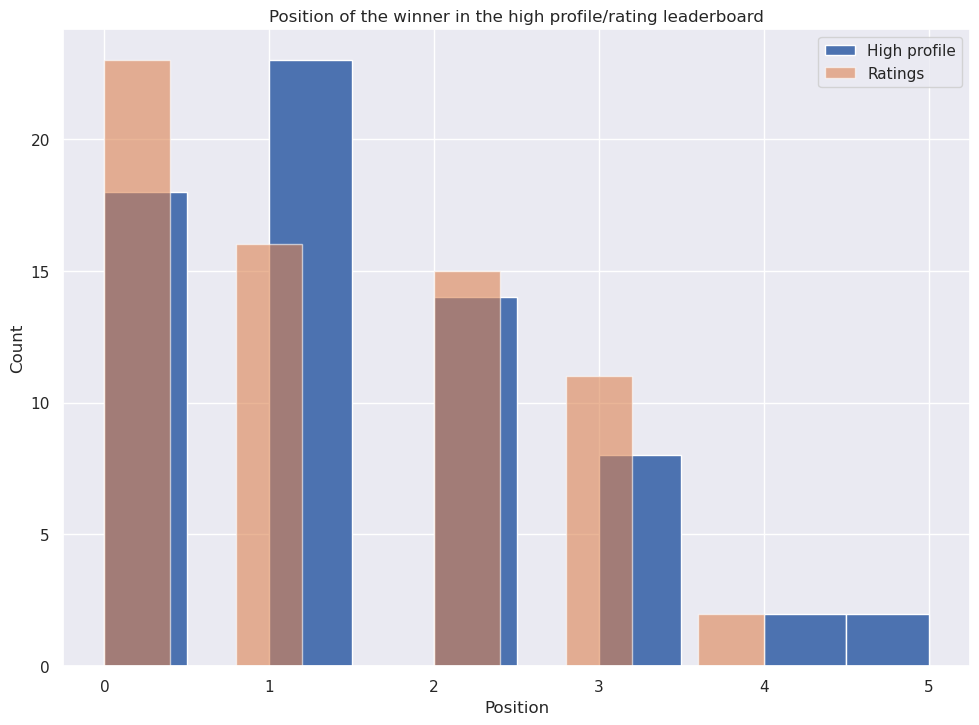

In [10]:
q3.plot_winner_position(df_Q3)

If each year, we sort the nominees by average ratings and by 'high profile score' in descending order, we see that the distributions are quite similar and heavy-tailed: oscar winning-movies are thus well rated and directed by a popular director.

To estimate how correlated both of these metrics are, we will compare their correlations each year. Additionnaly, one could use these metrics to fit a logistic regression to predict the binary outcome of whether a movie will win an oscar or not. Each year, we will train 2 logistic regression: one on the ratings only and one using both the ratings and the high profile score. This will result in a change of weight associated to the ratings that we will interpret.

Mean correlation from 1944 to 2012: 0.12813267123857638
Mean absolute correlation from 1944 to 2012: 0.5675852044635821


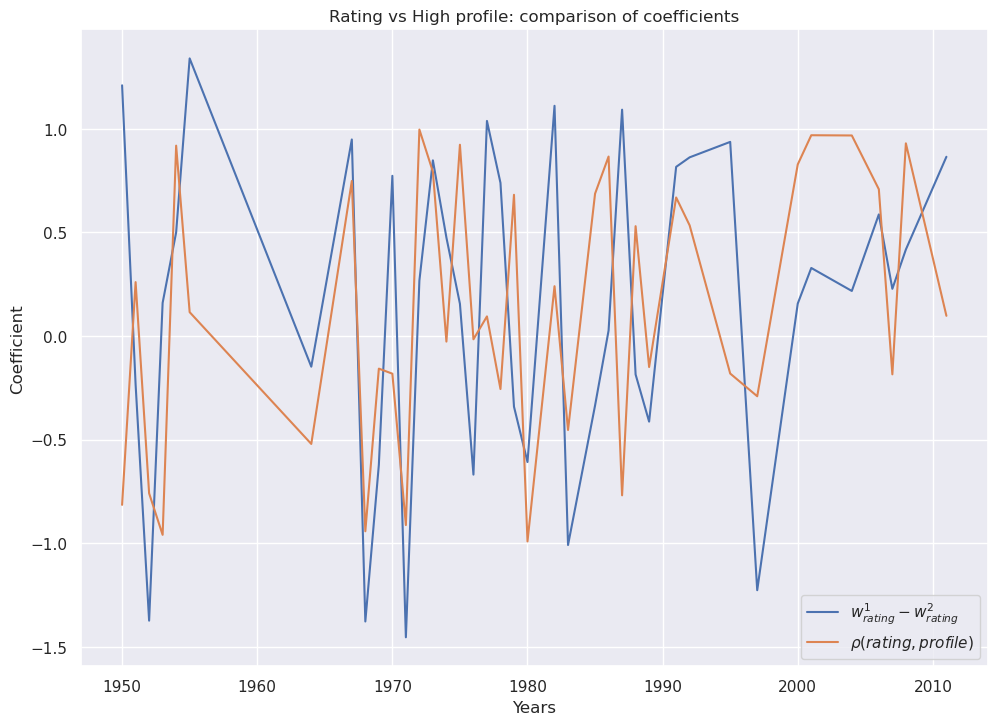

In [11]:
q3.plot_logreg_diff(df_Q3)

Despite being noisy, this graph showcases that the correlation and the difference of weights between the two logistic regression follow the same trend. However, they can be interpreted differently:

* When $w_{rating}^1 > w_{rating}^2$, it means that both features overlap and bring the same information, which confirms what we see with $\rho(rating, profile) > 0$.

* When $w_{rating}^1 < w_{rating}^2$, it means that the added feature brings complementary and independent information, which could mean that having $\rho(rating, profile) < 0$ could be due to noise.

Both of these approaches highlight the fact that no judges are biased towards high profile directors regardless of ratings as they are correlated.

### 4. Comparison with International Film Festivals: Oscars vs. Other Awards

In this part, we try to see the difference between a movie nominated or winner for Oscars and 2 other international awards: Bafta and Golden Globe.

The analysis was only made on movies that were present in all the datasets (nominated for all the awards). To improve the analysis for the next milestone, we can add movies nominated to the other international awards that were not necessarly there among the Oscars. Moreover, it would be interesting to look for more datasets for other international awards.

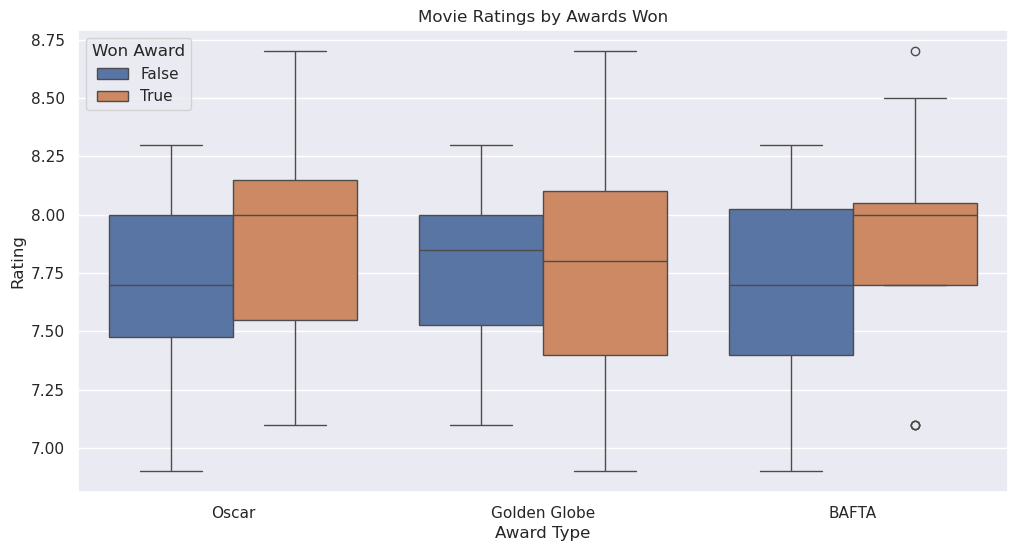

Average rating by number of awards won
   total_awards  averageRating
0             0       7.778571
1             1       7.638462
2             2       7.720000
3             3       8.050000


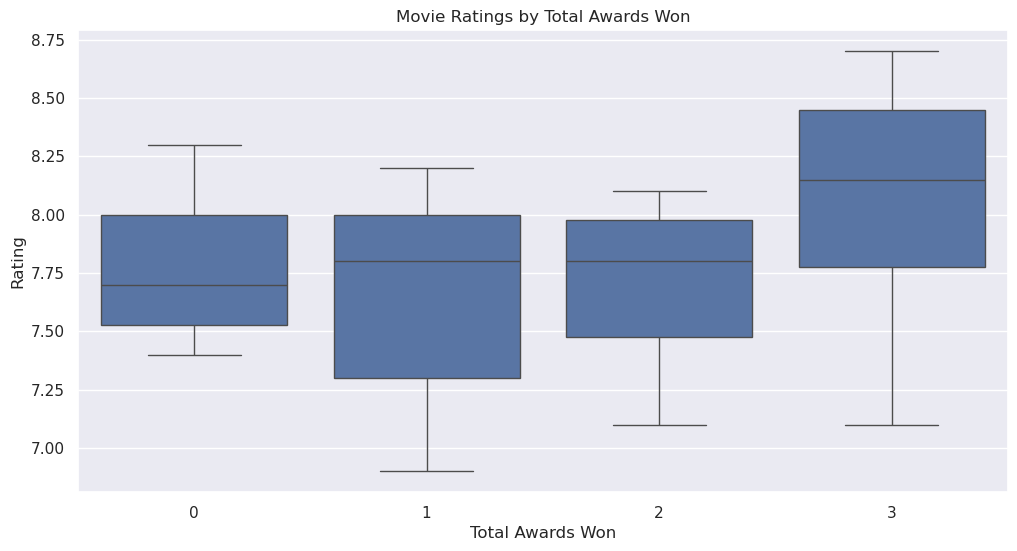

In [12]:
q4.ratings_by_awards()

The rating does not change much between a movie that wins an Oscar or the others.

We can see that the rating does not change much between 0 and 2 awards. But when winning 3, it significantly increases.

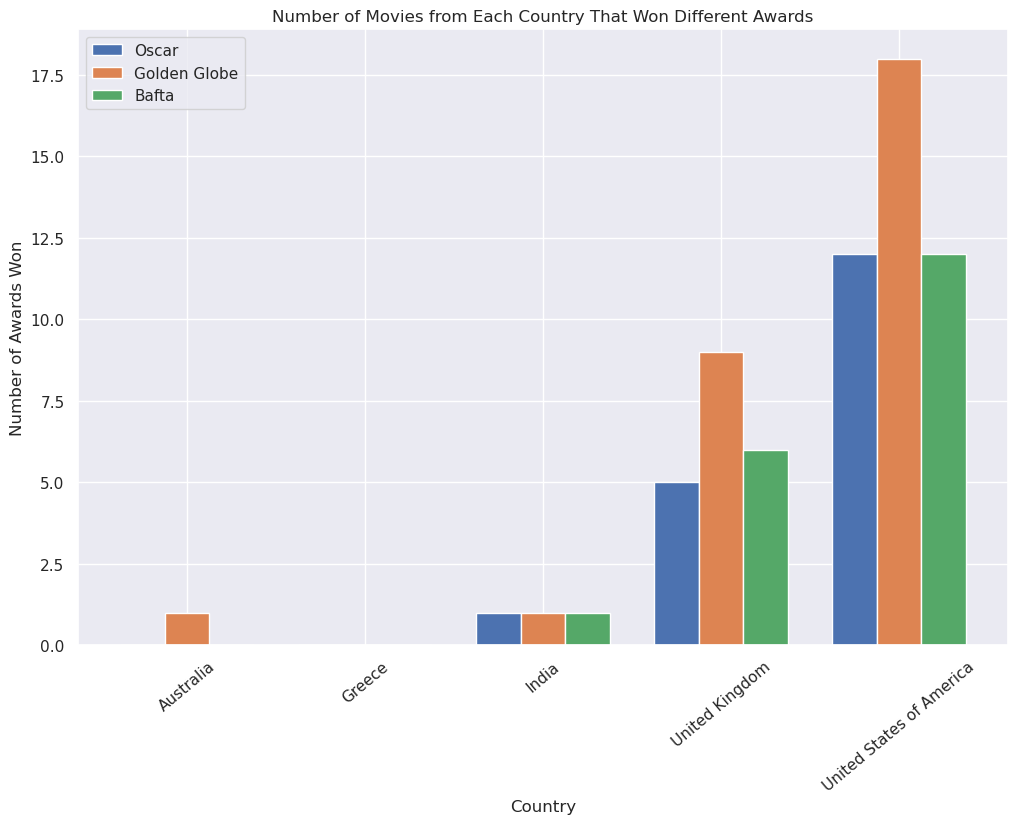

In [13]:
q4.awards_by_countries()

We see that the UK and the USA win more awards. The distribution does not really change among the different awards. Except that Golden Globes give more awards, that is because they have a category for each different genre.

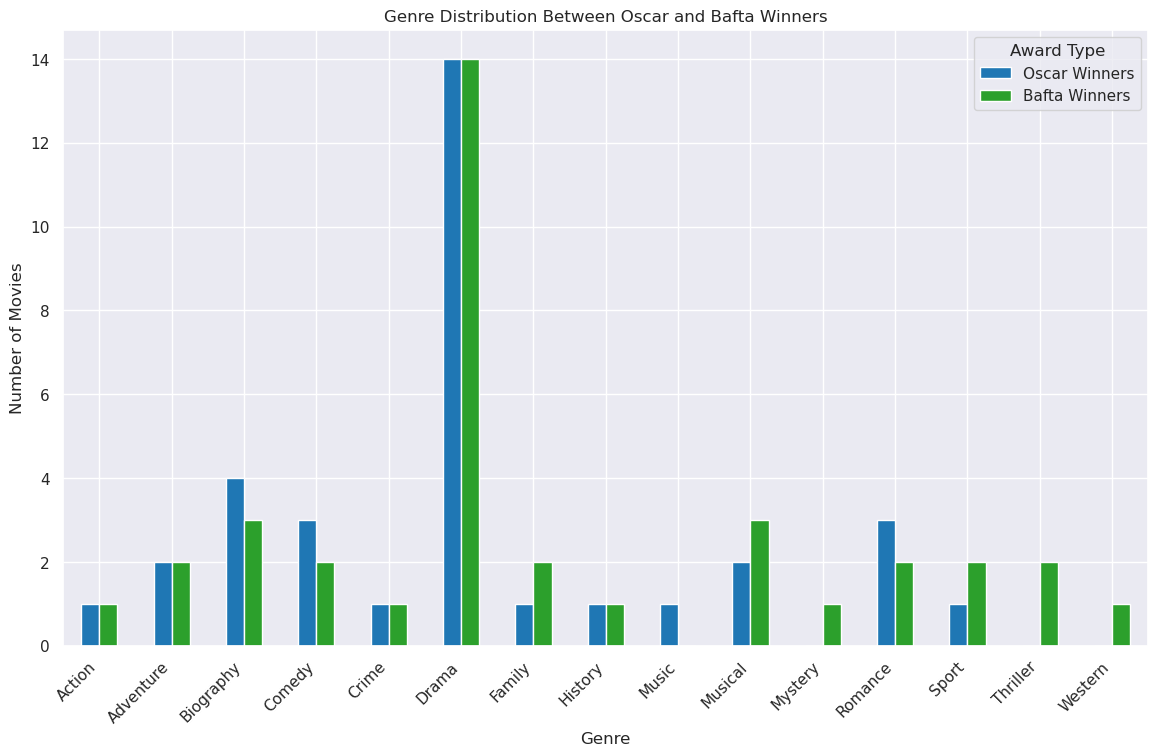

In [14]:
q4.awards_by_genre()

We see that the preferred category for a winning movie is drama for both of the awards. Golden Globes have categories by genre so we do not consider it here.

### 5. The Oscar Bump: Rating and Review Increases Post-Win

See point 2. for the definition of the "compound score".

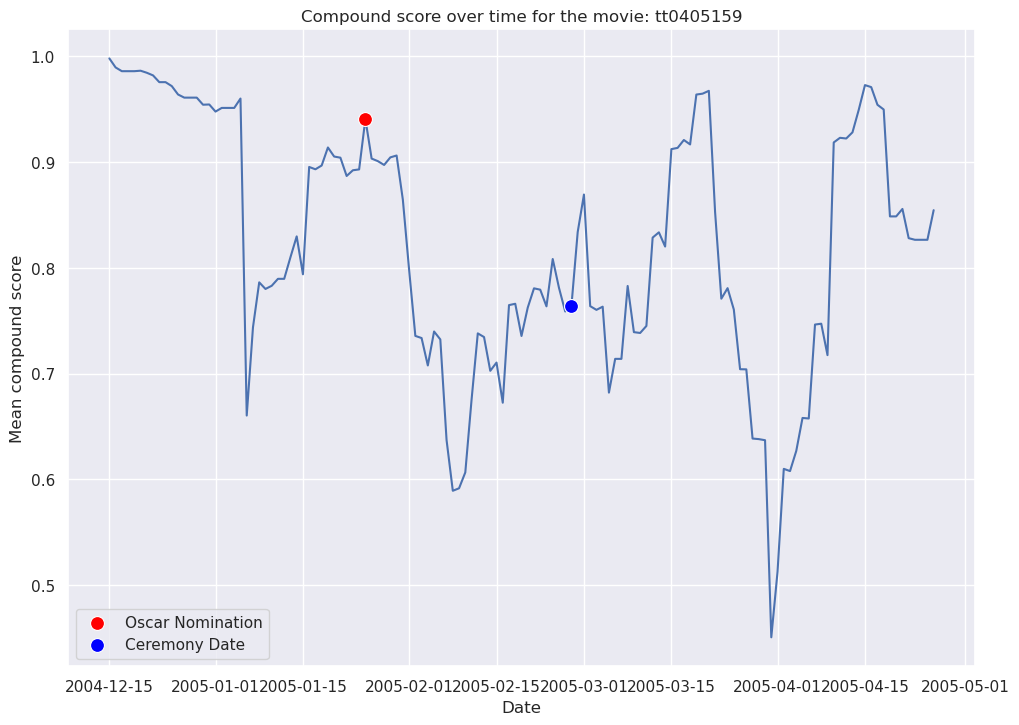

In [15]:
q5.plot_oscar_bump("compound")

We see that the compound score tends to drop after the nomination and rises again after the ceremony (in this case the film won the Oscar)

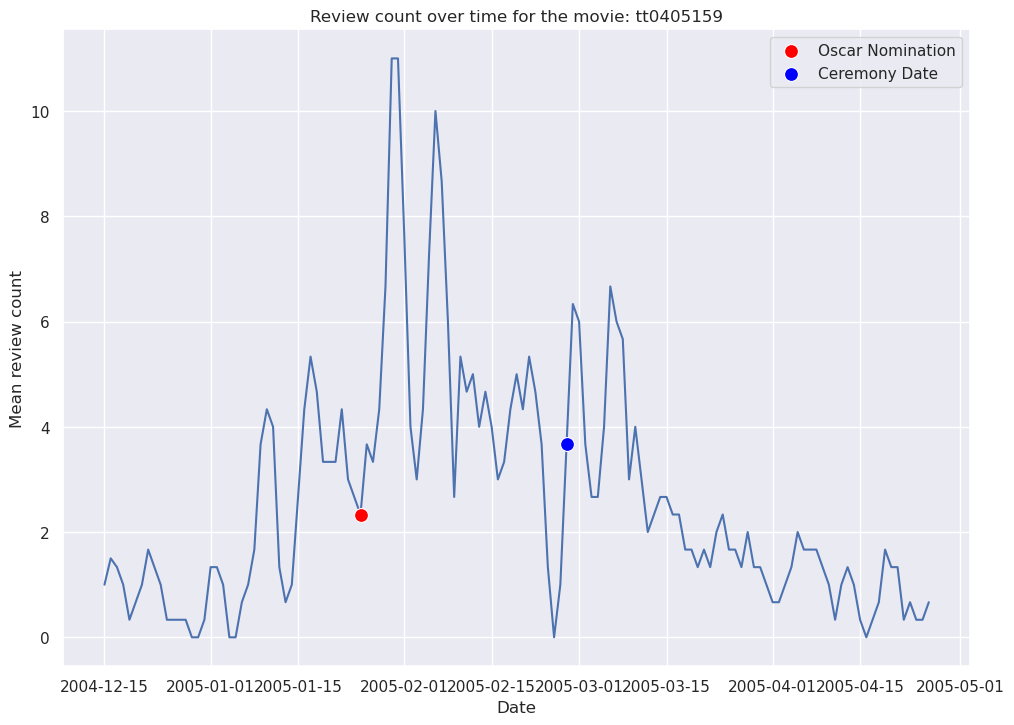

In [16]:
q5.plot_oscar_bump("count")

The number of reviews spikes two times: after the nomination and after the ceremony

### 6. Oscars jury vs Audience biases

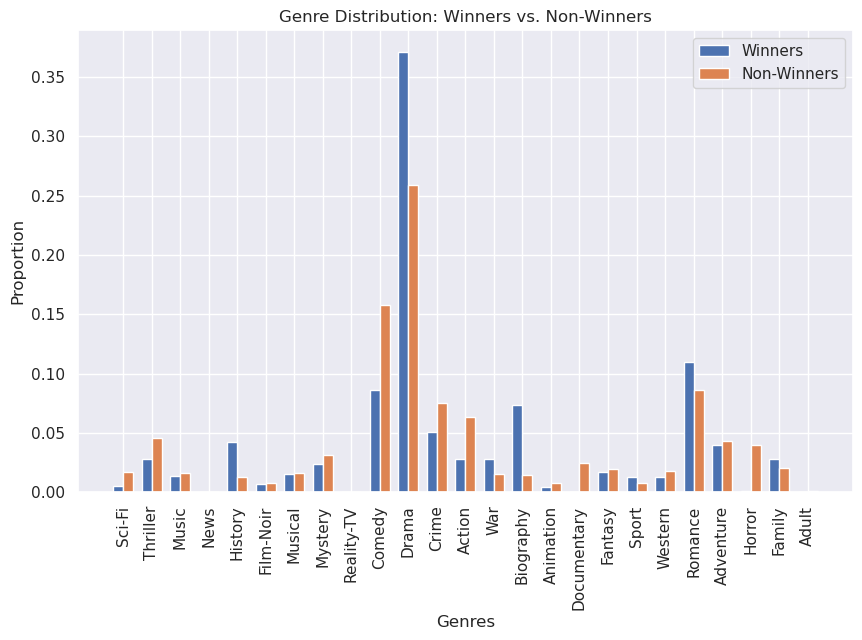

In [17]:
q6.plot_genre_distribution()

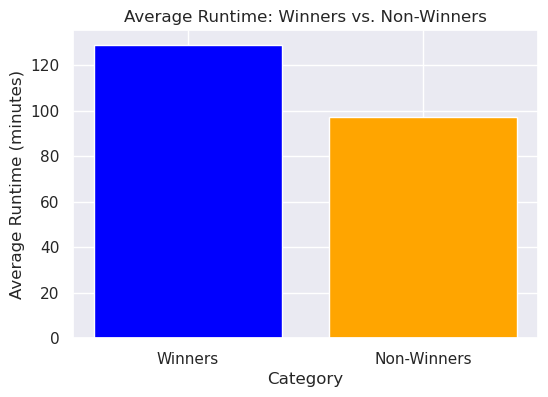

In [18]:
q6.plot_runtime_distribution()

## Summary

[To be completed after the analysis, during Milestone 3]